In [1]:
from importlib.metadata import version

pkgs = ['numpy', 'matplotlib', 'tiktoken', 'torch', 'transformers', 'tokenizers']
for p in pkgs:
    print(f"{p} version: {version(p)}")

!which python; python --version

numpy version: 2.1.2
matplotlib version: 3.9.2
tiktoken version: 0.9.0
torch version: 2.4.1
transformers version: 4.50.3
tokenizers version: 0.21.1
/mnt/lustre/work/macke/mwe102/.conda/sbi/bin/python
Python 3.10.15


In [2]:
import yaml
import os, math
import time, inspect
import urllib.request
from dataclasses import dataclass

import torch
import tiktoken
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

Need the following:
```python
# from norms import get_norm, get_final_norm
# from positional_embeddings import RotaryEmbedding, apply_rotary_pos_emb
```

In [3]:
def get_norm(config):
    eps = config.get('layernorm_epsilon', 1e-5)
    if config['norm'] == "layernorm_nonparam":
        norm = LayerNorm_NonParam
    elif config['norm'] == "layernorm":
        norm = nn.LayerNorm
    else:
        raise ValueError(f"norm {config['norm']} not recognized")
    return norm, eps


def get_final_norm(config):
    eps = config.get('layernorm_epsilon', 1e-5)
    if config['final_norm'] == "layernorm_nonparam":
        norm = LayerNorm_NonParam
    elif config['final_norm'] == "layernorm":
        norm = nn.LayerNorm
    else:
        raise ValueError(f"norm {config['final_norm']} not recognized")
    return norm, eps


class LayerNorm_NonParam(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.num_channels = dim
        self.eps = eps

    def forward(self, x):
        return F.layer_norm(x, normalized_shape=(self.num_channels,), eps=self.eps)

In [4]:
class RotaryEmbedding(torch.nn.Module):
    def __init__(
        self, dim, max_seq_len, base=10000, precision=torch.half, save_inv_freqs=False
    ):
        super().__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq, persistent=save_inv_freqs)
        self.seq_len_cached = None
        self.cos_cached = None
        self.sin_cached = None
        self.precision = precision
        self.max_seq_len = max_seq_len
        self.base = base
        self.dim = dim

        # precompute cos_cached, sin_cached in fp32
        cos_cached, sin_cached, inv_freq = self._prepare_cache(
            max_seq_len, precision, base
        )

        self.register_buffer("inv_freq", inv_freq, persistent=save_inv_freqs)
        self.cos_cached = cos_cached
        self.sin_cached = sin_cached

    def _prepare_cache(self, seq_len, precision, base):
        # precompute cos_cached, sin_cached in fp32
        inv_freq = 1.0 / (base ** (torch.arange(0, self.dim, 2).float() / self.dim))

        t = torch.arange(seq_len).type_as(inv_freq)
        freqs = torch.einsum("i,j->ij", t, inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)

        cos_cached = emb.cos()[:, None, None, :]
        sin_cached = emb.sin()[:, None, None, :]

        return (
            cos_cached.to(precision),
            sin_cached.to(precision),
            inv_freq.to(precision),
        )

    def forward(self, x, seq_dim=0, seq_len=None):
        if seq_len is None:
            seq_len = x.shape[seq_dim]

        assert seq_len <= self.max_seq_len

        if seq_len != self.max_seq_len:
            # y, z, _ = self._prepare_cache(seq_len, self.precision, self.base)
            return (
                self.cos_cached[:seq_len, ...].to(x.device),
                self.sin_cached[:seq_len, ...].to(x.device),
            )
        else:
            return self.cos_cached.to(x.device), self.sin_cached.to(x.device)


# rotary pos emb helpers:
def rotate_half(x):
    x1, x2 = x[..., : x.shape[-1] // 2], x[..., x.shape[-1] // 2 :]
    return torch.cat(
        (-x2, x1), dim=x1.ndim - 1
    )  # dim=-1 triggers a bug in earlier torch versions


@torch.jit.script
def apply_rotary_pos_emb(q, k, cos, sin, offset: int = 0):
    cos, sin = (
        cos[offset : q.shape[0] + offset, ...],
        sin[offset : q.shape[0] + offset, ...],
    )
    return (q * cos) + (rotate_half(q) * sin), (k * cos) + (rotate_half(k) * sin)


def apply_rotary_pos_emb_torch(
    q, k, cos, sin, offset: int = 0
):  # jitting fails with bf16
    cos, sin = (
        cos[offset : q.shape[0] + offset, ...],
        sin[offset : q.shape[0] + offset, ...],
    )
    return (q * cos) + (rotate_half(q) * sin), (k * cos) + (rotate_half(k) * sin)

In [5]:
def nonlinear_normalization(inputs, normalization_type, dim=-1):
    if normalization_type == 'gelu_l2_norm':
        nonlinear_outputs = F.gelu(inputs)
        norm_outputs = nonlinear_outputs / torch.norm(nonlinear_outputs, p=2, dim=dim, keepdim=True) * math.sqrt(nonlinear_outputs.shape[dim])
        outputs = norm_outputs
    elif normalization_type == 'l2_norm_gelu':
        norm_outputs = inputs / torch.norm(inputs, p=2, dim=dim, keepdim=True) * math.sqrt(inputs.shape[dim])
        nonlinear_outputs = F.gelu(norm_outputs)
        outputs = nonlinear_outputs
    else:
        raise NotImplementedError
    return outputs

In [6]:
class Pattention(nn.Module):
    """Parameter-based attention layer"""
    def __init__(self, input_channels, output_channels, param_token_num, normalization_type):
        super().__init__()
        self.key_param_tokens = nn.Parameter(torch.empty(param_token_num, input_channels))
        self.value_param_tokens = nn.Parameter(torch.empty(param_token_num, output_channels))
        self.normalization_type = normalization_type

    def forward(self, inputs):
        # Compute attention weights using dot product between inputs and key parameters
        attn_weights = inputs @ self.key_param_tokens.transpose(-2, -1)

        # Apply nonlinear normalization
        attn_weights = nonlinear_normalization(attn_weights, self.normalization_type)
    
        # Compute weighted sum with value parameters
        output = attn_weights @ self.value_param_tokens
        return output


class TokenFormerBlock(nn.Module):
    """Main TokenFormer layer block"""
    def __init__(self, hidden_size, qkv_slot_num, ffn_slot_num, proj_slot_num, config):
        super().__init__()

        self.normalization_type = config['norm_activation_type']
        self.num_attention_heads = config['num_attention_heads']
        self.hidden_size_per_attention_head = hidden_size // self.num_attention_heads
        
        # Get norm layers based on config
        norm, eps = get_norm(config)
        self.norm1 = norm(hidden_size, eps=eps)
        self.norm2 = norm(hidden_size, eps=eps)
        
        # Self-attention with parameter tokens
        self.query = Pattention(hidden_size, hidden_size, qkv_slot_num, self.normalization_type)
        self.key = Pattention(hidden_size, hidden_size, qkv_slot_num, self.normalization_type)
        self.value = Pattention(hidden_size, hidden_size, qkv_slot_num, self.normalization_type)
        self.proj = Pattention(hidden_size, hidden_size, proj_slot_num, self.normalization_type)
        
        # FFN
        self.ffn = Pattention(hidden_size, hidden_size, ffn_slot_num, self.normalization_type)

        # Initialize rotary embeddings
        self.rotary_emb = RotaryEmbedding(
            dim=int(self.hidden_size_per_attention_head * 0.25),  # 25% of dimensions
            base=10000,  # default base
            max_seq_len=config.get('max_position_embeddings', 2048),
            precision=torch.float16 if config.get('fp16', False) else torch.float32
        )

    def forward(self, x):
        # Self attention
        residual = x
        x = self.norm1(x)
        
        # Get Q,K,V through parameter attention
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        # Compute self-attention
        x = self.attention(q, k, v)
        
        # Project and add residual connection
        x = self.proj(x)
        x = residual + x
        
        # FFN
        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = residual + x
        
        return x

    def attention(self, q, k, v):

        # Reshape for attention heads
        b, s, h = q.size()
        q = q.view(b, s, self.num_attention_heads, self.hidden_size_per_attention_head)
        k = k.view(b, s, self.num_attention_heads, self.hidden_size_per_attention_head)
        v = v.view(b, s, self.num_attention_heads, self.hidden_size_per_attention_head)

        # At this point, dimensions are:
        # q, k: [batch_size, seq_len, num_heads, head_size]
 
        # Apply rotary embeddings to first 25% of dimensions
        rotary_ndims = int(self.hidden_size_per_attention_head * 0.25)
        
        # Split the dimensions for partial rotary
        q_rot, q_pass = q[..., :rotary_ndims], q[..., rotary_ndims:]
        k_rot, k_pass = k[..., :rotary_ndims], k[..., rotary_ndims:]
        
        # After split:
        # q_rot, k_rot: [batch_size, seq_len, num_heads, rotary_ndims]
        # q_pass, k_pass: [batch_size, seq_len, num_heads, (head_size - rotary_ndims)]

        # Get and apply rotary embeddings
        seq_len = q.size(1)
        cos, sin = self.rotary_emb(q, seq_len=seq_len)
        q_rot, k_rot = apply_rotary_pos_emb(q_rot, k_rot, cos, sin, offset=0)
        
        # Recombine rotary and pass-through dimensions
        q = torch.cat((q_rot, q_pass), dim=-1)
        k = torch.cat((k_rot, k_pass), dim=-1)
        
        # Transpose for attention calculation
        q = q.transpose(1, 2)  # [b, nh, s, hs]
        k = k.transpose(1, 2)  # [b, nh, s, hs]
        v = v.transpose(1, 2)  # [b, nh, s, hs]
        
        # Create causal mask with proper dimensions
        causal_mask = torch.triu(
            torch.ones((1, 1, seq_len, seq_len), dtype=torch.bool, device=q.device), 
            diagonal=1
        )
        attn_mask = torch.where(causal_mask, float('-inf'), 0.0)
        
        # Compute attention scores with proper scaling and normalization
        scale = 1 / math.sqrt(self.hidden_size_per_attention_head)
        attn_weights = (q @ k.transpose(-2, -1)) * scale  # [b, nh, s, s]
        attn_weights = attn_weights + attn_mask
        attn_weights = F.softmax(attn_weights, dim=-1)
        
        # Apply attention to values
        x = attn_weights @ v  # [b, nh, s, hs]

        # Reshape and return
        x = x.transpose(1, 2).contiguous().view(b, s, h)
        return x


class TokenFormer(nn.Module):
    """TokenFormer model for inference"""
    def __init__(
        self,
        vocab_size=50257,
        hidden_size=768,
        num_layers=12,
        qkv_slot_num=768,
        ffn_slot_num=3072,
        proj_slot_num=768,
        max_position_embeddings=2048,
        config=None
    ):
        super().__init__()
        
        # Token embeddings
        self.word_embeddings = nn.Embedding(vocab_size, hidden_size)
        
        # TokenFormer layers
        self.layers = nn.ModuleList([
            TokenFormerBlock(
                hidden_size=hidden_size,
                qkv_slot_num=qkv_slot_num,
                ffn_slot_num=ffn_slot_num,
                proj_slot_num=proj_slot_num,
                config=config
            ) for _ in range(num_layers)
        ])
        
        # Get final norm based on config
        final_norm, final_eps = get_final_norm(config)
        self.norm_f = final_norm(hidden_size, eps=final_eps)
        
        self.output = nn.Linear(hidden_size, vocab_size, bias=False)

        # initialize and report number of parameters
        self.initialize_parameters()
        print("init and number of parameters: %.2fM" % (self.get_num_params()/1e6,))
    
    def initialize_parameters(self):
        """
        since all trainable tokens are in nn.Parameter containers, they need
        to be initialized by hand as pytorch won't do it
        """
        std = 0.02
        for name, param in self.named_parameters():
            if ('weight' in name) or ('param_tokens' in name):
                if param.dim() >= 2:
                    torch.nn.init.normal_(param, mean=0.0, std=0.02)
                else:
                    torch.nn.init.zeros_(param) # for 1d bias like params (if any)
            elif 'bias' in name:
                torch.nn.init.zeros_(param)

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        Note that here they are not doing weight tying for some reason, i.e.,
        `self.word_embeddings.weight` is not same as `self.output.weight`
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.word_embeddings.weight.numel()
        return n_params
        
    def forward(self, input_ids, targets=None):
        # Embeddings
        hidden_states = self.word_embeddings(input_ids)
        
        # Forward through layers
        for layer in self.layers:
            hidden_states = layer(hidden_states)
            
        # Final norm and output projection
        hidden_states = self.norm_f(hidden_states)
        logits = self.output(hidden_states)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.flatten(0, 1), targets.flatten())
        
        return logits, loss

    def configure_optimizers(self, weight_decay, learning_rate, device):
        # just pick out params that require grad
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}

        # create optim groups -- all 2d params will be weight decayed, biases and layernorms no decay
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]

        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and "cuda" in device
        print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        
        return optimizer

In [7]:
import tiktoken
from tokenizer import build_tokenizer

def load_config(model_type='150M'):
    assert model_type in {'150M', '450M', '900M', '1-5B'}
    config_path = f'../tokenformer-minimal/config/{model_type}_eval.yml'
    with open(config_path, 'r') as f:
        return yaml.safe_load(f)

model_size = '150M'
config = load_config(model_type=model_size)

# Initialize tokenizer
tokenizer = build_tokenizer(
    tokenizer_type=config['tokenizer-type'],
    vocab_file=config['vocab-file'],
    padding_multiple=128
)

# regular gpt2 tokenizer used in nanoGPT
enc = tiktoken.get_encoding("gpt2")

Building tokenizer...


In [8]:
# config['tokenizer-type'], config['vocab-file']

In [9]:
tokenizer.tokenize("Hello, I'm a language model,"), tokenizer.detokenize([12092, 13, 309, 1353, 247, 3448, 1566, 13])

([12092, 13, 309, 1353, 247, 3448, 1566, 13], "Hello, I'm a language model,")

In [10]:
enc.encode("Hello, I'm a language model,"), enc.decode([15496, 11, 314, 1101, 257, 3303, 2746, 11]), enc.decode([12092, 13, 309, 1353, 247, 3448, 1566, 13])

([15496, 11, 314, 1101, 257, 3303, 2746, 11],
 "Hello, I'm a language model,",
 ' coup. T top�pri until.')

In [11]:
tokenizer.vocab_size, tokenizer.padded_vocab_size

(50277, 50304)

## Skip the below cells and move to the pretraining cells to initialize model from scratch

In [12]:
# # Move model to GPU if available
# device = "cpu"
# if torch.cuda.is_available():
#     device = "cuda"
# elif hasattr(torch.backends, "mps") and torch.mps.is_available():
#     device = "mps"
# print(f"using device: {device}")
# # device = "cpu" # OVERRIDE

# torch.manual_seed(1337)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(1337)


# # Initialize model
# model_size = '150M'
# config = load_config(model_type=model_size)

# model = TokenFormer(
#     vocab_size = tokenizer.padded_vocab_size,
#     hidden_size = config['hidden_size'],
#     num_layers = config['num_layers'],
#     qkv_slot_num = config['qkv_slot_num'],
#     ffn_slot_num = config['ffn_slot_num'],
#     proj_slot_num = config['proj_slot_num'],
#     max_position_embeddings = config['max_position_embeddings'],
#     config=config
# )
# model = model.to(device)

In [13]:
# model

In [14]:
# param_dict = dict(model.named_parameters())

In [15]:
# for key in param_dict.keys():
#     print(key)

In [16]:
# param_dict

## 1. check fineweb val-loss on randomly initialized model

In [17]:
## test on val data
def load_tokens(filename: str):
    # expects .npy file
    npt = np.load(filename)
    ptt = torch.tensor(npt, dtype=torch.long)
    return ptt

class DataLoaderLite:

    def __init__(self, B, T, process_rank=0, num_processes=1, split='train', data_root='edu_fineweb10B_tokenformer'):
        self.B, self.T = B, T
        self.process_rank = process_rank
        self.num_processes = num_processes
        assert split in {'train', 'val'}

        # get the shard filename
        data_root = data_root
        shards = os.listdir(data_root)
        shards = [s for s in shards if split in s]
        shards = sorted(shards)
        shards = [os.path.join(data_root, s) for s in shards]
        self.shards = shards
        assert len(shards) > 0, f"no shards found for split: {split}"
        master_process = process_rank == 0
        if master_process:
            print(f"with data root: {data_root} found: {len(shards)} shards for: {split} split and num processes: {self.num_processes}")

        # state management
        self.reset()

    def reset(self):
        # useful in val_loader.reset()
        # state, initialize at shard 0 or first file
        self.current_shard = 0
        self.tokens = load_tokens(self.shards[self.current_shard])
        self.current_position = self.B * self.T * self.process_rank


    def next_batch(self):
        # prepare inputs and targets for a single *step* of the optimization
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]
        x = buf[:-1].view(B, T) # remove last token
        y = buf[1:].view(B, T)  # remove first token
        # advance to the next chunk of the array
        self.current_position += (B * T * self.num_processes)
        # check for next batch loading for all processes
        # if loading the next batch would be out of bounds, advance to next shard
        if self.current_position + (B*T*self.num_processes + 1) > len(self.tokens):
            self.current_shard = (self.current_shard + 1) % len(self.shards)
            self.tokens = load_tokens(self.shards[self.current_shard])
            self.current_position = B * T * self.process_rank
        return x, y

# B = 32   # micro batch size: how many rows we are processing in a single forward-backward step (32 fits in one A100 40GB, was 16 earlier)
# T = 1024 # sequence length
# # initialize the dataloader
# val_loader = DataLoaderLite(B=B, T=T, split='val', data_root='edu_fineweb10B_tokenformer')

In [18]:
def calc_loss_loader(data_loader, model, device, num_batches, print_loss=True) -> float:
    model.eval()
    data_loader.reset()

    with torch.no_grad():
        loss_accum = 0.0
        loss_steps = num_batches
        for _ in range(loss_steps):
            x, y = data_loader.next_batch()
            x, y = x.to(device), y.to(device)
            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                logits, loss = model(x, y)
            loss = loss / loss_steps
            # print(f'loss at step {_}: {loss.detach().item():.4f}')
            loss_accum += loss.detach()
    
    if print_loss:
        # averaged per-step loss, averaged over `num_batches` batches or steps
        print(f"Validation loss: {loss_accum.item():.4f}")
    
    model.train()
    return loss_accum.item()

In [19]:
# generate_and_print_samples(model, tokenizer, device)
print(f"Val loss for random tokenformer {model_size}: {calc_loss_loader(val_loader, model, device, num_batches=20)}")

Observation: It is comparable to GPT2 loss of around 10, so everything going good so far!

## 2. load official pre-trained weights and check its val-loss

In [38]:
def create_mapping(num_layers):
    # Create mapping for model weights
    remap_dict = {
        'sequential.0.word_embeddings': 'word_embeddings'
    }
    
    # Map layers
    for i in range(2, num_layers + 2):
        new_idx = i - 2
        remap_dict[f'sequential.{i}.attention'] = f'layers.{new_idx}'
        remap_dict[f'sequential.{i}.mlp'] = f'layers.{new_idx}.ffn'
    
    # Map final norm
    remap_dict[f'sequential.{num_layers + 3}.norm'] = 'norm_f'
    
    return remap_dict


def load_model(model, weights_path, num_layers):
    """Load model weights from state dict"""
    state_dict = torch.load(weights_path, weights_only=True)
    
    remap_dict = create_mapping(num_layers)
    
    # Copy output weight from word embeddings if missing
    if 'output.weight' not in state_dict:
        state_dict['output.weight'] = state_dict['sequential.0.word_embeddings.weight']
    
    # Rename keys in-place by replacing prefixes
    for old_prefix, new_prefix in remap_dict.items():
        for key in list(state_dict.keys()):
            if key.startswith(old_prefix):
                new_key = key.replace(old_prefix, new_prefix, 1)
                state_dict[new_key] = state_dict.pop(key)
    
    model.load_state_dict(state_dict)

In [39]:
# Initialize model
model = TokenFormer(
    vocab_size = tokenizer.padded_vocab_size,
    hidden_size = config['hidden_size'],
    num_layers = config['num_layers'],
    qkv_slot_num = config['qkv_slot_num'],
    ffn_slot_num = config['ffn_slot_num'],
    proj_slot_num = config['proj_slot_num'],
    max_position_embeddings = config['max_position_embeddings'],
    config=config
)
model = model.to(device)

print(f"Loading pre-trained tokenformer {model_size} weights on {device}...")
model_bin_file = f'../tokenformer-minimal/pytorch_model_{model_size}.bin'
load_model(model, model_bin_file, config['num_layers'])

init and number of parameters: 151.88M
Loading pre-trained tokenformer 150M weights on cuda...


In [41]:
# dict(model.named_parameters())

In [42]:
# generate_and_print_samples(model, tokenizer, device)
print(f"Val loss for pre-trained tokenformer {model_size}: {calc_loss_loader(val_loader, model, device, num_batches=20)}")

Validation loss: 6.4403
Val loss for pre-trained tokenformer 150M: 6.440320014953613


Observation: Hmm, this looks a bit suspicious! I think GPT2 124M had a validation loss of around $3.24$ on the same set. Not sure if everythin is working correctly.
- I made sure to compute the validation loss on a tokenformer tokenized version of fineweb, and not the GPT2 tiktoken one.
- I need to check what they report in the paper, may be I need to check on the owt dataset instead of fineweb!
- 
### Using pre-trained weights from Tokenformer is a pain!
- It is using a different tokenizer, not the tiktoken gpt2 tokenizer!
- I created another version of the fineweb tokenized data using this tokenizer to test this model!!!

In [41]:
def generate_and_print_samples(model, tokenizer, device,
                               num_return_sequences = 4,
                               max_length = 32,
                               start_context = "Hello, I'm a language model,",
                               random_seed = 42
                               ):
    
    model.eval()
    encoder = None
    decoder = None
    if hasattr(tokenizer, 'encode'):
        encoder = tokenizer.encode
        decoder = tokenizer.decode
    elif hasattr(tokenizer, 'tokenize'):
        encoder = tokenizer.tokenize
        decoder = tokenizer.detokenize
    else:
        raise ValueError(f"Please pass a tokenizer with either encode/decode or tokenize/detokenize methods")

    
    tokens = encoder(start_context)
    tokens = torch.tensor(tokens, dtype=torch.long)
    tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
    xgen = tokens.to(device)
    # don't interfere with other seeds
    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(random_seed)

    while xgen.size(1) < max_length:
        # forward the model to get the logits
        with torch.no_grad():
            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                logits, loss = model(xgen) # (B, T, vocab_size)
            # take the logits at the last position
            # print(logits.shape, logits.dtype)
            logits = logits[:, -1, :] # (B, vocab_size)
            # get the probabilities
            probs = F.softmax(logits, dim=-1)
            # do top-k sampling of 50 (huggingface pipeline default)
            # topk_probs here becomes (5, 50), topk_indices is (5, 50)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            # select a token from the top-k probabilities
            # note: multinomial does not demand the input to sum to 1
            ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
            # gather the corresponding indices
            xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
            # append to the sequence
            xgen = torch.cat((xgen, xcol), dim=1)
    # print the generated text
    for i in range(num_return_sequences):
        tokens = xgen[i, :max_length].tolist()
        decoded = decoder(tokens)
        print(f"sample {i}: {decoded}")
    
    model.train()


In [44]:
generate_and_print_samples(model, tokenizer, device)

sample 0: Hello, I'm a language model, I'm from the, we can not your English, please. A is I, the your English is to, is
sample 1: Hello, I'm a language model, computer graphics trainer, a lot more video, a way an online
can

you. I just.
be
sample 2: Hello, I'm a language model, a new born girl new boy,

s, I don'ts, it,

c, a kid
sample 3: Hello, I'm a language model, you should be


I need
very
I use in my you here is your as if I should can


In [195]:
# generate_and_print_samples(model, enc, device) # doesn't work with tiktoken tokenizer

In [45]:
enc.n_vocab, enc.special_tokens_set

(50257, {'<|endoftext|>'})

In [46]:
tokenizer.vocab_size

50277

In [47]:
tokenizer.vocab['<|endoftext|>'] # another difference from the tiktoken tokenizer!!!

0

# Pre-training code

## Dataloader for the fineweb dataset (assuming shards are already available)
- since I am pretraining from scratch, I will just use the original GPT2 fwt data tokenized with tiktoken

In [21]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.mps.is_available():
    device = "mps"
print(f"using device: {device}")
# device = "cpu" # OVERRIDE

torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

using device: cuda


In [22]:
total_batch_size = 524_288 # 2**19, closest power of 2 to ~0.5M
B = 8    # micro batch size: how many rows we are processing in a single forward-backward step (16 fits nicht in one A100 40GB)
T = 1024 # sequence length
assert total_batch_size % (B * T) == 0, "total batch size in number of tokens should be divisible by B*T"
grad_accum_steps = total_batch_size // (B * T)
print(f"total desired batch size: {total_batch_size} tokens")
print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

# initialize the dataloader
train_loader = DataLoaderLite(B=B, T=T, split='train', data_root='edu_fineweb10B')
val_loader = DataLoaderLite(B=B, T=T, split='val', data_root='edu_fineweb10B')

# initialize tokenizer for sampling through the model
# enc = tiktoken.get_encoding("gpt2")

total desired batch size: 524288 tokens
=> calculated gradient accumulation steps: 64
with data root: edu_fineweb10B found: 99 shards for: train split and num processes: 1
with data root: edu_fineweb10B found: 1 shards for: val split and num processes: 1


In [23]:
# enable tf32, now matmuls will use tf32 (tensor cores from A100)
torch.set_float32_matmul_precision('high') # default is highest

In [24]:
max_lr = 6e-4 # prev constant lr that we were using
min_lr = max_lr * 0.1
warmup_steps = 100
max_steps = 6001

In [25]:
def get_lr(it):
    # linear warmup
    if it < warmup_steps:
        return max_lr * (it + 1) / warmup_steps
    # if it > lr decay iters, return min_lr
    if it > max_steps:
        return min_lr
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # starts at 1, goes to 0
    return min_lr + coeff * (max_lr - min_lr)

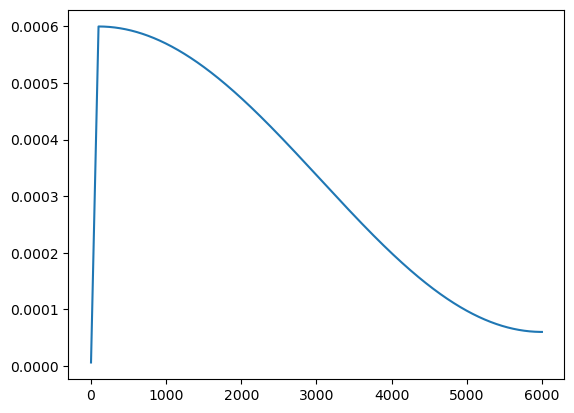

In [26]:
steps = np.arange(max_steps)
lrs = np.array([get_lr(it) for it in steps])

plt.plot(steps, lrs); plt.show()

In [27]:
tokenizer.padded_vocab_size

50304

In [28]:
model_size = '150M'
config = load_config(model_type=model_size)

model = TokenFormer(
    vocab_size = tokenizer.padded_vocab_size,
    hidden_size = config['hidden_size'],
    num_layers = config['num_layers'],
    qkv_slot_num = config['qkv_slot_num'],
    ffn_slot_num = config['ffn_slot_num'],
    proj_slot_num = config['proj_slot_num'],
    max_position_embeddings = config['max_position_embeddings'],
    config=config
)
model = model.to(device)

use_compile = True # torch.compile interferes with HellaSwag eval and Generation. TODO fix
if use_compile:
    model = torch.compile(model) # 4th optimization

optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device=device) # fused update

max_steps = 6001
val_loss_steps = 20
for step in range(max_steps):

    # once in a while evaluate on the validation set
    if step % 100 == 0:
        _ = calc_loss_loader(val_loader, model, device, num_batches=val_loss_steps)

    # once in a while sample from the model
    if step % 100 == 0:# and (not use_compile):
        generate_and_print_samples(model, enc, device)

    # start timer
    t0 = time.time()
    model.train()
    optimizer.zero_grad()
    loss_accum = 0.0

    # gradient-accumulation
    for micro_step in range(grad_accum_steps):
        # data loading
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)
    
        # forward-backward and step
        # amp for 3rd optimization, just surround forward pass and loss calculation, only possible in A100
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model(x, y)
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward() # deposits gradients, i.e., += on nodes

    # clip gradient norms to 1.0, returns total norm of the gradient vector
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # determine lr for this step
    lr = get_lr(step)
    # pytorch syntax to set the learning rate for the parameters
    for param_group in optimizer.param_groups:
        # param_group is a dict
        param_group['lr'] = lr
    optimizer.step()

    # wait for gpu to finish the compute and measure time
    torch.cuda.synchronize()
    t1 = time.time()

    dt = (t1 - t0)*1000 # time difference for one-batch or step in miliseconds
    tokens_processed = train_loader.B * train_loader.T * grad_accum_steps
    tps = tokens_processed / (t1 - t0)

    # only print every 20 steps to reduce clutter
    if step % 10 == 0:
        print(f"Step {step:4d} | loss: {loss_accum.item():.6f} | lr: {lr:.4e} | norm: {norm:.4f} | dt: {dt:.2f}ms | tok/sec: {tps:.2f}")


print(f"logits.shape: {logits.shape}, logits dtype: {logits.dtype}, loss.dtype: {loss.dtype}")

init and number of parameters: 151.88M
num decayed parameter tensors: 122, with 190,513,152 parameters
num non-decayed parameter tensors: 2, with 1,536 parameters
using fused AdamW: True
Validation loss: 10.8258
sample 0: Hello, I'm a language model,K3*5"+0,?7EI;1=&01A(#3H&
sample 1: Hello, I'm a language model,97B*#5OHM#A5/LB%Q#4:1QI<
sample 2: Hello, I'm a language model,/N:5=/B<M.=O)%%A:DJCP*&9
sample 3: Hello, I'm a language model,'7J%8($/+K;'D.L3FA/K4E87
Step    0 | loss: 10.825845 | lr: 6.0000e-06 | norm: 0.0687 | dt: 109628.65ms | tok/sec: 4782.40
Step   10 | loss: 10.824967 | lr: 6.6000e-05 | norm: 0.1053 | dt: 6528.14ms | tok/sec: 80311.98
Step   20 | loss: 10.820913 | lr: 1.2600e-04 | norm: 0.1286 | dt: 6569.00ms | tok/sec: 79812.48
Step   30 | loss: 10.806940 | lr: 1.8600e-04 | norm: 0.1899 | dt: 6587.19ms | tok/sec: 79592.10
Step   40 | loss: 10.767907 | lr: 2.4600e-04 | norm: 0.3034 | dt: 6611.66ms | tok/sec: 79297.52
Step   50 | loss: 10.686462 | lr: 3.0600e-04 | norm: 0.

In [29]:
model

OptimizedModule(
  (_orig_mod): TokenFormer(
    (word_embeddings): Embedding(50304, 768)
    (layers): ModuleList(
      (0-11): 12 x TokenFormerBlock(
        (norm1): LayerNorm_NonParam()
        (norm2): LayerNorm_NonParam()
        (query): Pattention()
        (key): Pattention()
        (value): Pattention()
        (proj): Pattention()
        (ffn): Pattention()
        (rotary_emb): RotaryEmbedding()
      )
    )
    (norm_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (output): Linear(in_features=768, out_features=50304, bias=False)
  )
)

In [36]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: True
    lr: 6.0000038263286916e-05
    maximize: False
    weight_decay: 0.1

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: True
    lr: 6.0000038263286916e-05
    maximize: False
    weight_decay: 0.0
)

In [54]:
tokenizer.padded_vocab_size

50304

In [30]:
from datetime import datetime

In [31]:
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f'run id: {run_id}')

run id: 20250408_101716


In [38]:
def save_checkpoint(model: nn.Module, optimizer=None,
                    name='', root_dir='./checkpoint'):

    run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
    dic = {
        "model_state_dict": model.state_dict(),
    }
    if optimizer is not None:
        dic["optimizer_state_dict"] = optimizer.state_dict()

    filename = os.path.join(root_dir, f'model_and_optimizer_{name}_{run_id}.pth')
    torch.save(dic, filename)   

""" loading code
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();
"""

' loading code\ncheckpoint = torch.load("model_and_optimizer.pth", weights_only=True)\n\nmodel = GPTModel(GPT_CONFIG_124M)\nmodel.load_state_dict(checkpoint["model_state_dict"])\n\noptimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)\noptimizer.load_state_dict(checkpoint["optimizer_state_dict"])\nmodel.train();\n'

In [39]:
# save_checkpoint(model, optimizer, name=model_size, root_dir='./checkpoints/')

In [40]:
print(f"Val loss for trained tokenformer {model_size}: {calc_loss_loader(val_loader, model, device, num_batches=50)}")

Validation loss: 3.4034
Val loss for trained tokenformer 150M: 3.403391122817993


In [42]:
enc

<Encoding 'gpt2'>

In [52]:
generate_and_print_samples(model, enc, device,
                           random_seed=torch.randint(100, (1, )).item()
                          )

sample 0: Hello, I'm a language model, so I might be a lot more complicated than C++ which is a very powerful language that is very simple for all that
sample 1: Hello, I'm a language model, as I'm afraid it's not so much my style as our approach to doing the homework. However, if you're
sample 2: Hello, I'm a language model, I'm doing this. If you like, it's very well.
Anyway, what we have to do is,
sample 3: Hello, I'm a language model, and I'm my own mother. I am a non-verbal learner. I'm also an English language learner


In [53]:
model

OptimizedModule(
  (_orig_mod): TokenFormer(
    (word_embeddings): Embedding(50304, 768)
    (layers): ModuleList(
      (0-11): 12 x TokenFormerBlock(
        (norm1): LayerNorm_NonParam()
        (norm2): LayerNorm_NonParam()
        (query): Pattention()
        (key): Pattention()
        (value): Pattention()
        (proj): Pattention()
        (ffn): Pattention()
        (rotary_emb): RotaryEmbedding()
      )
    )
    (norm_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (output): Linear(in_features=768, out_features=50304, bias=False)
  )
)

In [1]:
model

NameError: name 'model' is not defined

### next todos:
- init tokenformer
- check tokenformer's validation losses for each size compared to gpt2
- start `build-tokenformer-fineweb` notebook

### 1. example snapshot
```
number of parameters: 123.69M
num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
Validation loss: 10.9597
Step    0 | loss: 10.958449 | lr: 6.0000e-06 | norm: 15.6885 | dt: 40388.14ms | tok/sec: 12981.24
Step    1 | loss: 10.628062 | lr: 1.2000e-05 | norm: 12.3712 | dt: 3312.92ms | tok/sec: 158255.62
Step    2 | loss: 10.245197 | lr: 1.8000e-05 | norm: 7.8265 | dt: 3318.94ms | tok/sec: 157968.57

...

Step   49 | loss: 7.107584 | lr: 3.0000e-04 | norm: 0.7933 | dt: 3401.66ms | tok/sec: 154127.19
Validation loss: 7.1122
Step   50 | loss: 7.174483 | lr: 3.0600e-04 | norm: 1.1656 | dt: 3402.44ms | tok/sec: 154091.90

...

Step   97 | loss: 6.434902 | lr: 5.8800e-04 | norm: 0.6139 | dt: 3407.81ms | tok/sec: 153849.04
Step   98 | loss: 6.499994 | lr: 5.9400e-04 | norm: 0.8524 | dt: 3409.96ms | tok/sec: 153752.11
Step   99 | loss: 6.449703 | lr: 6.0000e-04 | norm: 0.6719 | dt: 3403.89ms | tok/sec: 154026.12
Validation loss: 6.4133
Step  100 | loss: 6.484104 | lr: 6.0000e-04 | norm: 0.8199 | dt: 3409.96ms | tok/sec: 153752.01
logits.shape: torch.Size([32, 1024, 50304]), logits dtype: torch.bfloat16, loss.dtype: torch.float32

```

### 2. without `torch.compile` and with sample generation
```
number of parameters: 123.69M
num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
Validation loss: 10.9514
sample 0: Hello, I'm a language model,CHR 351ointmentprotantically surrounded flaw TCUorigin Effective surrounded senate rodents�oviribution Feinstein Homer tappedrica relentlessppedribution 351
sample 1: Hello, I'm a language model,iggs Socialism Yangointment rodents contributors investigatesteness emulator toughestClientTesla "[ricaSTE TI TI Places TFencersRRArray Privacy undone
sample 2: Hello, I'm a language model, glimpserint236udzee unve Neighvanceces arise Account Student Privacy Privacy beloved Christina Patterns sugg Sche continental iCloudflo 2012Listener
sample 3: Hello, I'm a language model, unvewarts evoke investigates investigateswsws Magnetmens Art altercationperformanceribution roast368 senate Actinguls breastignmentmissing facesmare supremacists
Step    0 | loss: 10.955029 | lr: 6.0000e-06 | norm: 15.3463 | dt: 4813.04ms | tok/sec: 108930.64
Step    1 | loss: 10.631693 | lr: 1.2000e-05 | norm: 11.6429 | dt: 3883.76ms | tok/sec: 134995.12
Step    2 | loss: 10.274923 | lr: 1.8000e-05 | norm: 7.6928 | dt: 4039.76ms | tok/sec: 129781.83

...

Step   48 | loss: 7.203589 | lr: 2.9400e-04 | norm: 1.5565 | dt: 4001.99ms | tok/sec: 131006.80
Step   49 | loss: 7.104921 | lr: 3.0000e-04 | norm: 0.9878 | dt: 4004.38ms | tok/sec: 130928.52
Validation loss: 7.1181
sample 0: Hello, I'm a language model,000, we by a first in these new used of the the it at that the.
There in your the.
sample 1: Hello, I'm a language model, so by the body.
The future.” of a an make that it, he the small of the and
sample 2: Hello, I'm a language model, and the year of the new by any the “- A the same the other for the the own the first with
sample 3: Hello, I'm a language model, they do the world.
The small to they you the work on the most is not them to not the two all
Step   50 | loss: 7.178192 | lr: 3.0600e-04 | norm: 1.5985 | dt: 3992.52ms | tok/sec: 131317.66

...

Step   99 | loss: 6.446934 | lr: 6.0000e-04 | norm: 0.5210 | dt: 4014.07ms | tok/sec: 130612.47
Validation loss: 6.4060
sample 0: Hello, I'm a language model, if you
As a great
In those it?
This, an the
The work?
the
I
sample 1: Hello, I'm a language model, then just all that he was not know that the year” (H” (A, she had in the
sample 2: Hello, I'm a language model, the first very been taken at the area of children than the
-time, or three-based, the same was
sample 3: Hello, I'm a language model, they was a very a long-a is going to the end it has the "a-ces. It

Step  100 | loss: 6.474727 | lr: 6.0000e-04 | norm: 0.5555 | dt: 4012.42ms | tok/sec: 130666.34
Step  101 | loss: 6.422134 | lr: 5.9949e-04 | norm: 0.8457 | dt: 4013.04ms | tok/sec: 130645.99

...

Step  149 | loss: 6.160313 | lr: 6.2046e-05 | norm: 0.1937 | dt: 4005.23ms | tok/sec: 130900.94
Validation loss: 6.1286
sample 0: Hello, I'm a language model, when the one of a way is also used after the book of our mother of the way to that it will be in
sample 1: Hello, I'm a language model, there also an important for a good one of this particular-p) would do you are much of our family. You
sample 2: Hello, I'm a language model, and the need, because in the idea of any process of these things to the need to be a certain of a sense
sample 3: Hello, I'm a language model, it comes to be a person, they can try to you use our home and is your brain, as you are that
Step  150 | loss: 6.167456 | lr: 6.0512e-05 | norm: 0.1955 | dt: 3995.44ms | tok/sec: 131221.58
logits.shape: torch.Size([32, 1024, 50304]), logits dtype: torch.bfloat16, loss.dtype: torch.float32

```

In [14]:
!nvidia-smi

Mon Apr  7 11:32:50 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:01:00.0 Off |                    0 |
| N/A   41C    P0              70W / 250W |  39747MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [15]:
del model
del logits
del x, y

with torch.no_grad():
    torch.cuda.empty_cache()

In [16]:
del optimizer

In [17]:
torch.cuda.is_bf16_supported()

True

In [18]:
!nvidia-smi

Mon Apr  7 11:33:05 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:01:00.0 Off |                    0 |
| N/A   41C    P0              63W / 250W |  20879MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--